## Predicting ad positioning using Q-Learning

Placement of ads on website is the primary problem for companies that operate on ad revenue. The position where the ad is placed plays pivotal role on whether or not the ad will be clicked. Here we have the following choices:
1. Place them randomly, or
2. Place the ad on the same position

The problem with placing the ad on the same position is the user, after a certain time, will start ignoring the space since he's used to seeing ad at the place, he will end up ignoring that particular position hereafter. Hence, this will reduce the number of clicks on ads. The problem with the former option, placing them randomly, is it wouldn't take optimal positions into consideration. For instance, text beside images are viewed higher number of times than those text which are placed at a distance. It is infeasible to go through every website and repeat the procedure. 

Solution: Reinforcement Learning

Using Reinforcement Learning we can approximate the human behavior. 

### Why Reinforcement Learning? 
We cannot use traditional Machine Learning here, since it requires:
1. Huge data
2. Features
3. Tuning of many hyperparameters

And we neither have huge data, nor features. The only data we have is the position of the banner/ad and whether or not it was clicked. We will use this dataset from Kaggle: https://www.kaggle.com/akram24/ads-ctr-optimisation. We will solve this problem using both model-based (Policy iteration) and model-free methods(Q-Learning & Monte-Carlo). We'll simplify some assumptions for model-based technique. 

### Notebook Layout
1. MDP environment - Understanding the dataset
2. Random Policy - placing the ads randomly on different webpages
3. Max policy - placing the ad where it is clicked maximum number of times
4. Model-based Method - Policy Iteration
5. Model-free Method - Q-learning & Monte Carlo

#### Importing Libraries

In [2]:
# import routines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

#### Dataset

Our environment will be the dataset. It contains 10 ads position per row having values either 1, when the ad is clicked, or 0 when it is not. Every row can be considered as a state in the space, considering it kind of a navigation across multiple pages (on website, for instance) Lets load the dataset and visualize the first few rows.

1. state = webpage
2. action = placing the ad at any of the 10 positions on a webpage
3. reward = +1 if the ad was clicked at the position; else 0
4. Transition Probability: next webpage that user will end up in is random; therefore, it is 1/(total_webpages -1)

In [3]:
env = pd.read_csv('Ads_CTR_Optimisation.csv')
env.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


## Random policy

If we were to not have Reinforcement Learning, we would place the ads randomly at given positions. We will now simulate the same.  

In [4]:
# total rewards earned
reward = 0
# random policy: for every state, choose a random
# position for displaying the ad
for x in range(len(env)):
    action = np.random.randint(0, 10)
    # if the guess was correct, increase the reward
    if env.values[x][action] == 1:
        reward += 1
print("Reward collected: {}".format(reward))

Reward collected: 1263


## Using Max Policy
Another question we might ask: is it right to display the ad where it is clicked the most number of times. For instance, there might be a certain position where the ad clicked with a higher probability. Since the values of the rows is either 1 or 0, we can sum across the columns and count the number of times ad in the position was clicked. 

In [5]:
clicked_counts = env.values.sum(axis=0)
counts = pd.DataFrame({"ad": np.arange(1, 11), "counts": clicked_counts})
counts.set_index("ad")

,counts
ad,
1,1703
2,1295
3,728
4,1196
5,2695
6,126
7,1112
8,2091
9,952


Which indicates ad 5 was clicked 2695 times. So if we were to always place an ad on position 5, it would be click around 2695 times. But can we do better? 

## Dynamic Programming (Policy Iteration) 

In [6]:
len(env)

10000

In [7]:
# starting with random policy, choose a random choice for every state in the environment
state_size = len(env)

state_list = []
for state in range(state_size):
    state_list.append(state)

In [8]:
start = time.time()
# action could be placing the ad on any of the 10 positions
action_space = np.arange(0, 10)

policy = [random.choice(action_space) for x in range(state_size)]
# will take random action for the first time
first_time = True

# delta
small_change = 1e-20
# discount factor
gamma = 0.9
episodes = 0
max_episodes = 500

V = dict()
# last positions reward will be 1 - terminal state
V[10000] = 1

# initially the value function for all states will be random values close to zero
for i in range(state_size):
    V[i] = np.random.random()
deltas = []
while episodes < max_episodes:
    # policy evaluation (until convergence of state value function)
    while True:
        if episodes > max_episodes:
            break
        episodes += 1
        if episodes % 100 == 0:
            print("Current episode: {}".format(episodes))
        biggest_change = 0
        # loop through every state present
        for state in range(state_size):
            old_V = V[state]
            # take random action according to policy
            action = policy[state]
            #print(action)
            new_state = random.choice(list(set(state_list) - set([state])))
            #print(new_state)
            reward = env.values[state][action]
            #
            V[state] = (reward + gamma * V[new_state])/9999
            # We're calculating biggest change to have an idea on convergence. 
            # Initially, the changes will be huge, but as 
            # we update the values, they will tend towards a convergence point
            biggest_change = max(biggest_change, abs(V[state] - old_V))
        deltas.append(biggest_change)
        if biggest_change < small_change:
            break
            
    # policy improvement
    policy_changed = False
    for state in range(state_size):
        best_val = -np.inf
        best_action = -1
        for action in action_space:
            new_state = random.choice(list(set(state_list) - set([state])))
            reward = env.values[state][action]
            # calculate the action with the best
            # future reward
            future_reward = (reward + gamma * V[new_state])/9999
            if future_reward > best_val:
                best_val = future_reward
                best_action = action
        assert best_action != -1
        # After convergence, the policy will not change since we would have already reached
        # the optimum policy. So check if the policy is not updated, if not then stop. 
        if policy[state] != best_action:
            policy_changed = True
        policy[state] = best_action

    if not policy_changed:
        break

end = time.time()
print("Time taken in seconds: ", end-start)
print("Total episodes trained: {}".format(episodes))

Current episode: 100
Current episode: 200
Current episode: 300
Current episode: 400
Current episode: 500
Time taken in seconds:  1232.5882132053375
Total episodes trained: 501


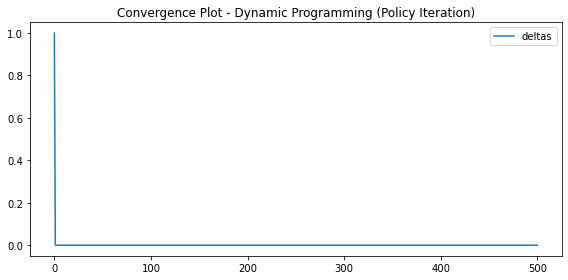

In [9]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.plot(deltas, label="deltas")
plt.legend()
plt.title("Convergence Plot - Dynamic Programming (Policy Iteration)")
plt.tight_layout()

In [10]:
# total rewards earned
reward = 0
# random policy: for every state, choose a random
# position for displaying the ad
for x in range(len(env)):
    action = policy[x]
    # if the guess was correct, increase the reward
    if env.values[x][action] == 1:
        reward += 1
print("Reward collected: {}".format(reward))

Reward collected: 7424


## Using Q-Learning

The reason for using Q-Learning here is :
1. It is model free, so it doesn't require to know all the states.
2. Intuitive to understand, and converges faster. 

We will use Q-Learning with Epsilon Decay. Initially, we will start with a very high epsilon value. Which would make the model explore, instead of exploit. After a few iterations, we will reduce this "exploration probability" so the model will exploit, instead of exploring. After many iterations, the model would have high confidence and no more exploration is necessary. 

This strategy is called as "epsilon greedy". We will use a decay rate to change the epsilon value such that it becomes lower after many iterations. 


In [11]:
# using q-learning
states = len(env)
actions = 10
# initialize q-table with zeros. Initially all the q-values will be zero
q_table = np.zeros((states + 1, actions))

learning_rate = 0.7
gamma = 0.618

# set the exploration probability to be very high initially. 
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01
max_episodes = 500

In [12]:
def exploit(eps):
    """Randomizes a number to select
    whether or not to expolit"""
    return np.random.uniform() > eps

def random_action():
    return np.random.randint(0, 10)

In [13]:
deltas = []
reward = 0
for episode in range(max_episodes + 1):
    if episode % 50 == 0:
        print("Episode: {}".format(episode))
    biggest_change = 0
    for state in range(states):
        if exploit(epsilon):
            action = random_action()
        else:
            action = np.argmax(q_table[state])
        r = env.values[state][action]
        reward += r
        old_q = q_table[state][action]
        new_state = random.choice(list(set(state_list) - set([state])))
        q_table[state][action] += learning_rate*(r + gamma*np.max(q_table[new_state, :]) - 
                                                 q_table[state][action])
        biggest_change = max(biggest_change, np.abs(q_table[state][action] - old_q))
    # keep track of biggest changes
    deltas.append(biggest_change)
    # epsilon decay to reduce exploration and increase exploitation
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)

Episode: 0
Episode: 50
Episode: 100
Episode: 150
Episode: 200
Episode: 250
Episode: 300
Episode: 350
Episode: 400
Episode: 450
Episode: 500


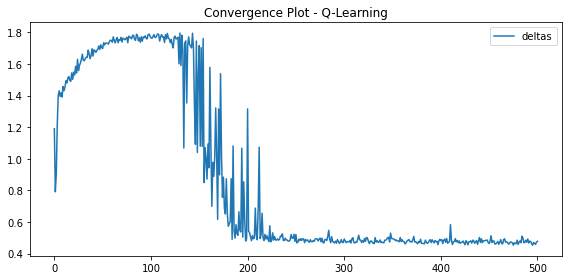

In [14]:
plt.plot(deltas, label="deltas")
plt.legend()
plt.title("Convergence Plot - Q-Learning")
plt.tight_layout()

In [15]:
# test
rewards = 0
for state in range(states):
    best_action = np.argmax(q_table[state, :])
    r = env.values[state][best_action]
    rewards += r
print("Reward collected: {}".format(rewards))

Reward collected: 7424


## Monte Carlo


In [16]:
def random_policy(state):
    """Returns a random available choice"""
    return np.random.randint(0, 10)

def simulate(policy):
    # store the reward-state-action triple
    rsa = []
    for s in range(env.shape[0]):
        # 10% probability that the agent will act randomly
        if np.random.uniform() < 0.1:
            action = np.random.randint(0, 10)
        else:
            action = policy[s]
        reward = env.values[s][action]
        rsa.append((reward, s, action))
        
    # go reverse and distribute rewards
    G = 0
    gamma = 0.3
    first = True
    state_returns = []
    for reward, s , a in reversed(rsa):
        G = G + gamma * reward
        if first:
            first = False
            continue
        else:
            state_returns.append((s, a, G))
    # we want the rewards to be the way they were distributed
    state_returns.reverse()
    return state_returns

In [17]:
from collections import defaultdict

# creates a random policy for every timestep
policy = {s: np.random.randint(0, 10) for s in range(10000)}
Q = np.zeros(env.values.shape)
returns = defaultdict(list)
deltas = []
max_iterations = 2000
for x in range(max_iterations):
    if x % 100 == 0:
        print(x)
    # simulate an episode, and get the
    # reward-state-action triple
    state_returns = simulate(policy)
    change = 0.0
    for state, action, G in state_returns:
        old_q = Q[state][action]
        returns[(state, action)].append(G)
        # calculates the average returns of being in this state
        Q[state][action] = np.mean(returns[(state, action)])
        # save the change so we can later on visualize the rate of convergence
        change = np.maximum(change, np.abs(Q[state][action] - old_q).astype(np.int))
    deltas.append(change)
    for s in range(10000):
        policy[s] = np.argmax(Q[s, :])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


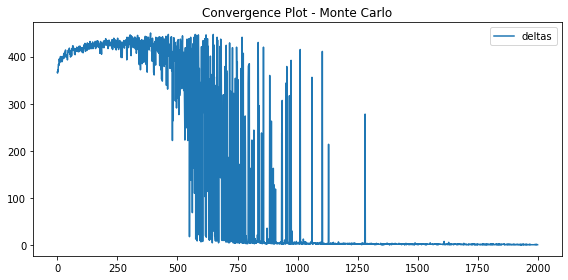

In [18]:
plt.plot(deltas, label="deltas")
plt.legend()
plt.title("Convergence Plot - Monte Carlo")
plt.tight_layout()

In [19]:
# once the policy is learnt, we will test it on the actual environment
reward = 0
for s in range(10000 - 1):
    a = np.argmax(Q[s, :])
    reward += env.values[s][a]
print(reward)

1541


In [21]:
l = [5, 5, 10, 4, 4, 4, 5, 5, 5, 10, 4, 4, 4, 5, 5, 5]
sum(l)/len(l)


5.25